# Generate Product Coding Sheet
To support understanding if VLMs can accurately identify products in images, this notebook helps to create a spreadsheet for human coders

# Setup

In [2]:
import os
import copy
import json
import csv
from datetime import datetime

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# Load Data
We need a couple data files: 
1. A csv that specifies what images we want in our human coding sample
2. The full dataset with Cap F1 computed

In [3]:
target_images_dtypes = {
    "image_id": int,
    "file_name": str,
    "vizwiz_url": str,
    "image_preview": str,
    "INCLUDE because product": str,
    "EXCLUDE because not verifable": str,
    "EXCLUDE because Book/DVD/CD/magazine?": str,
    "text_detected": bool,
    "unrecognizable": int,
    "framing": int,
    "blur": int,
    "obstruction": int,
    "rotation": int,
    "too dark": int,
    "too bright": int,
    "other": int,
    "no issue": int,
    "human_caption_0": str,
    "human_caption_1": str,
    "human_caption_2": str,
    "human_caption_3": str,
    "human_caption_4": str,
    "gpt-4o-2024-08-06_caption": str,
    "Llama-3.2-11B-Vision-Instruct_caption": str,
    "Molmo-7B-O-0924_caption": str,
    "general_notes": str,
    "gpt-4o-2024-08-06_notes": str,
    "Llama-3.2-11B-Vision-Instruct_notes": str,
    "Molmo-7B-O-0924_notes": str,
}

# load csv of target images
target_images_df = pd.read_csv(
    "Combined Caption Output (7304 Images) _ 03-29-25 - All Captioned Images.csv",
    dtype=target_images_dtypes,
    keep_default_na=False,
)
target_images_df.head()

,image_id,file_name,vizwiz_url,image_preview,INCLUDE because product,EXCLUDE because not verifable,EXCLUDE because Book/DVD/CD/magazine?,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,human_caption_0,human_caption_1,human_caption_2,human_caption_3,human_caption_4,gpt-4o-2024-08-06_caption,Llama-3.2-11B-Vision-Instruct_caption,Molmo-7B-O-0924_caption,general_notes,gpt-4o-2024-08-06_notes,Llama-3.2-11B-Vision-Instruct_notes,Molmo-7B-O-0924_notes,Column 1,Column 2
0,24,VizWiz_train_00000024.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,,,False,1,5,2,1,0,2,1,0,0,A person holding up a white piece of paper.,A hand holding a paper over a black object.,A person's hand holding a white piece of paper.,Quality issues are too severe to recognize vis...,Pictured is a portion of someone's hand holdin...,A hand is holding the edge of a piece of paper...,The image depicts a hand grasping a silver obj...,A hand holding a white piece of paper. The pap...,,,,,,
1,28,VizWiz_train_00000028.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,,,False,2,4,4,0,0,0,1,0,1,Possibly can being held up to camera above kit...,Beautiful view from behind the walls hidden un...,Quality issues are too severe to recognize vis...,Close up of blue can with partial image of bar...,Quality issues are too severe to recognize vis...,A blurred close-up of a white and blue object ...,The image appears to show a black cord with a ...,A blue and white box with a barcode is visible...,,,,,,
2,38,VizWiz_train_00000038.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,,,False,1,5,0,0,0,0,1,0,0,The corner of a black display screen sitting o...,A black tablet is resting on a wood table top.,Quality issues are too severe to recognize vis...,The corner of a black device sitting on a wood...,A peace of glass keep on the table shown in th...,A partially visible CD case with a black cover...,The image appears to show a smartphone with a ...,"A black rectangular object, likely a cell phon...",,,,,,
3,80,VizWiz_train_00000080.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,,,False,0,1,4,0,0,0,0,0,1,A leg with black jeans a black and white shoes.,A leg with black pants and a blue and white shoe.,A picture of someone's foot with a grey shoe on.,A pants leg with a pair of sneakers at the end...,a persons leg wearing black pants and a grey s...,A white and gray sneaker with laces is seen on...,"The image depicts a person's lower leg, clad i...",The image shows a person's leg wearing black p...,,,,,,
4,85,VizWiz_train_00000085.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,,,False,0,0,5,0,0,1,0,0,0,A black coffee maker plugged in on an at home ...,A black coffee maker is in the kitchen,A black coffee maker is on a brown surface.,an empty black coffee maker sitting on a white...,A black drip coffee maker sitting on a counter.,A black coffee maker with a glass carafe sits ...,The object is a black plastic bottle with a re...,A black coffee maker with a glass carafe and b...,,,,,,


In [4]:
# trim whitespace from INCLUDE because product, EXCLUDE because not verifable, and EXCLUDE because Book/DVD/CD/magazine?
target_images_df["INCLUDE because product"] = target_images_df[
    "INCLUDE because product"
].str.strip()
target_images_df["EXCLUDE because not verifable"] = target_images_df[
    "EXCLUDE because not verifable"
].str.strip()
target_images_df["EXCLUDE because Book/DVD/CD/magazine?"] = target_images_df[
    "EXCLUDE because Book/DVD/CD/magazine?"
].str.strip()

# make them uppercase
target_images_df["INCLUDE because product"] = target_images_df[
    "INCLUDE because product"
].str.upper()
target_images_df["EXCLUDE because not verifable"] = target_images_df[
    "EXCLUDE because not verifable"
].str.upper()
target_images_df["EXCLUDE because Book/DVD/CD/magazine?"] = target_images_df[
    "EXCLUDE because Book/DVD/CD/magazine?"
].str.upper()

# include if "INCLUDE because product" has an X; unrecognizable is 0 or 1; EXCLUDE because not verifable is NOT X; and EXCLUDE because Book/DVD/CD/magazine? is NOT X
target_images_df = target_images_df[
    (target_images_df["INCLUDE because product"] == "X")
    & (target_images_df["text_detected"] == True)
    & (
        (target_images_df["unrecognizable"] == 0)
        | (target_images_df["unrecognizable"] == 1)
    )
    & (target_images_df["EXCLUDE because not verifable"] != "X")
    & (target_images_df["EXCLUDE because Book/DVD/CD/magazine?"] != "X")
]
print(f"Original length of target images: {len(target_images_df)} images")
print(f"Length of target images after filtering: {len(target_images_df)} images")
target_images_df.head()

Original length of target images: 3158 images
Length of target images after filtering: 3158 images


,image_id,file_name,vizwiz_url,image_preview,INCLUDE because product,EXCLUDE because not verifable,EXCLUDE because Book/DVD/CD/magazine?,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,human_caption_0,human_caption_1,human_caption_2,human_caption_3,human_caption_4,gpt-4o-2024-08-06_caption,Llama-3.2-11B-Vision-Instruct_caption,Molmo-7B-O-0924_caption,general_notes,gpt-4o-2024-08-06_notes,Llama-3.2-11B-Vision-Instruct_notes,Molmo-7B-O-0924_notes,Column 1,Column 2
1874,812,VizWiz_train_00000812.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,X,,,True,1,5,5,0,0,0,0,0,0,a canned food item with a white label that has...,A Kroger Value brand can of diced tomatoes,A can of Kroger diced tomatoes with a red and ...,A can of Kroger's diced tomatoes on a counter ...,Quality issues are too severe to recognize vis...,A large can with a red and white label featuri...,The image appears to show a white plastic cont...,"The image shows a cylindrical container, likel...",,,,,,
1879,3226,VizWiz_train_00003226.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,X,,,True,0,5,5,0,0,0,0,0,0,Package of a cleaning product that is baby fri...,"A green, purple, and white container of a clea...",label of a product with an image of a child in...,"A package of soap, or some other bathing item,...",A person holding some sort of product to use i...,"A partial label showing the brand ""BabyGanics""...",The image shows a white box with a purple bath...,The image shows a person's hand holding a prod...,,,,,,
1881,4360,VizWiz_train_00004360.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,X,,,True,0,5,5,0,0,0,0,1,0,Front side of a plastic water bottle with juic...,The lower half of a can of Hawaiian Punch is v...,Bottle of Hawaiian Punch red fruit juice on a ...,A plastic bottle of a fruit juicy red flavored...,The bottom of a bottle of Hawaiian Punch,A red and blue label on a bottle with the visi...,The image shows a plastic bottle with a red la...,The image shows a bottle of fruit juice. The b...,,,,,,
1883,5513,VizWiz_train_00005513.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,X,,,True,0,5,5,0,0,0,2,0,0,A TV dinner box resting on a wooden floor.,A box containing some sort of pre-prepared din...,A package of food sits on a wooden surface.,A prepackage meal sits on a brown wooden surface.,"A boxed, breaded food item placed on oak flooring","Part of a food package with the text ""Cottage ...",The image appears to be a photograph of a froz...,A food package is visible on a wooden surface....,,,,,,
1886,7624,VizWiz_train_00007624.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,X,,,True,0,5,5,0,0,0,0,0,0,A person is holding a brown bottle with a gold...,A hand holds a bottle of something mostly out ...,a bottle of an unknown consumable with the wor...,A hand holding a brown bottle with a gold pape...,Someone holding a bottle that appears to be fr...,A hand is holding a brown bottle with a label ...,The image appears to be a hand holding a small...,A hand is holding a brown glass bottle with a ...,,,,,,


In [5]:
# create set we can use to filter
target_images_set = set(target_images_df["image_id"].astype(int).unique())

# save the list of target images
with open("target_images_set.json", "w") as f:
    json.dump([x.item() for x in target_images_set], f)

In [6]:
# load in evaluated caption data
evaluated_captions_data = json.load(
    open(
        "../../data/study-2-output/final-evaluated-captions/low-quality_evaluation_5432-images_2025-04-11_03-31_merged.json"
    )
)
filtered_evaluated_data = [
    d for d in evaluated_captions_data if d["image_id"] in target_images_set
]
print(f"Length of evaluated captions before filtering: {len(evaluated_captions_data)}")
print(f"Length of evaluated captions after filtering: {len(filtered_evaluated_data)}")
print(json.dumps(filtered_evaluated_data[0], indent=4))

Length of evaluated captions before filtering: 5432
Length of evaluated captions after filtering: 3158
{
    "image_id": 1,
    "file_name": "VizWiz_train_00000001.jpg",
    "vizwiz_url": "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg",
    "text_detected": true,
    "unrecognizable": 0,
    "framing": 0,
    "blur": 5,
    "obstruction": 0,
    "rotation": 0,
    "too dark": 0,
    "too bright": 0,
    "other": 0,
    "no issue": 0,
    "human_captions": [
        {
            "caption": "A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.",
            "is_precanned": false,
            "is_rejected": false
        },
        {
            "caption": "A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.",
            "is_precanned": false,
            "is_rejected": false
        },
        {
            "caption": "A kitchen counter the various items on top including a can of Coca-Cola,

# Create a view for the human coder
Now that we know which images to include, and have the full Cap F1 data loaded, we can create a view for the human coder.

In [7]:
relevant_keys = [
    "image_id",
]

cleaned_filtered_evaluated_data = []
for d in filtered_evaluated_data:
    # add keys from above
    cleaned_data = {k: d[k] for k in relevant_keys}

    # add a column unable to verify
    cleaned_data["unable_to_verify"] = ""
    # compress human captions into a single string joined by newlines
    cleaned_data["human_captions"] = "\n".join(
        [c["caption"] for c in d["human_captions"]]
    )

    # pull out cap f1 evaluation
    curr_cap_f1_eval = copy.deepcopy(d["evaluation"]["cap_f1"])
    cleaned_data["T_atomics"] = "\n".join(curr_cap_f1_eval["T_atomics"])

    model_short_name = {
        "gpt-4o-2024-08-06": "gpt4o",
        "Llama-3.2-11B-Vision-Instruct": "llama",
        "Molmo-7B-O-0924": "molmo",
    }
    for model, short_name in model_short_name.items():
        cleaned_data[f"{short_name}_g_atomics"] = "\n".join(
            curr_cap_f1_eval["g_atomics"][f"{model}"]
        )
        cleaned_data[f"{short_name}_recall_tp"] = "\n".join(
            curr_cap_f1_eval["metadata"][model]["recall"]["TPs"]
        )
        cleaned_data[f"{short_name}_recall_fn"] = "\n".join(
            curr_cap_f1_eval["metadata"][model]["recall"]["FNs"]
        )
        cleaned_data[f"{short_name}_precision_tp"] = "\n".join(
            curr_cap_f1_eval["metadata"][model]["precision"]["TPs"]
        )
        cleaned_data[f"{short_name}_precision_fp"] = "\n".join(
            curr_cap_f1_eval["metadata"][model]["precision"]["FPs"]
        )
        cleaned_data[f"{short_name}_code"] = ""

    # general notes column
    cleaned_data["notes"] = ""

    # add to new dataset
    cleaned_filtered_evaluated_data.append(cleaned_data)

# save the cleaned data
cleaned_filtered_evaluated_data[0]

{'image_id': 1,
 'unable_to_verify': '',
 'human_captions': 'A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.\nA black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.\nA kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.\na black tin of Coca Cola placed on a black surface\nBlack counter with canisters, kettle and can of soda.',
 'T_atomics': 'There is a can of Coca Cola.\nThe can is on a counter.\nThe can is black.\nThe can is of Coca Cola Zero calorie soda.\nThe can is near the coffee maker.\nThere is a kitchen counter.\nThere are various items on the kitchen counter.\nThere are metal containers on the kitchen counter.\nThere is a teapot on the kitchen counter.\nThere is a black counter.\nThere are canisters on the counter.\nThere is a kettle on the counter.',
 'gpt4o_g_atomics': 'There is a can of Coca-Cola Zero.\nThe can is on a kitchen countertop.\nThere is a white mug n

In [8]:
# convert to dataframe
cleaned_filtered_evaluated_data_df = pd.DataFrame(cleaned_filtered_evaluated_data)

# merge with target images
relevant_keys = ["image_id", "file_name", "vizwiz_url", "image_preview"]

# use this if you want image quality data
# relevant_keys = [
#     "image_id",
#     "file_name",
#     "vizwiz_url",
#     "image_preview",
#     "text_detected",
#     "unrecognizable",
#     "framing",
#     "blur",
#     "obstruction",
#     "rotation",
#     "too dark",
#     "too bright",
#     "other",
#     "no issue",
# ]
human_coder_df = pd.merge(
    target_images_df[relevant_keys],
    cleaned_filtered_evaluated_data_df,
    on="image_id",
    how="inner",
)
human_coder_df.sort_values(by="image_id", inplace=True)
human_coder_df.reset_index(drop=True, inplace=True)
display(human_coder_df.head())

# randomize the order of the rows
human_coder_df = human_coder_df.sample(frac=1)
display(human_coder_df.head())

# print number of rows
print(len(human_coder_df))

# save the human coder dataframe
human_coder_df.to_csv(
    f"./data-to-label/spreadshet-to-code_{len(human_coder_df)}-images_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv",
    index=False,
)

,image_id,file_name,vizwiz_url,image_preview,unable_to_verify,human_captions,T_atomics,gpt4o_g_atomics,gpt4o_recall_tp,gpt4o_recall_fn,gpt4o_precision_tp,gpt4o_precision_fp,gpt4o_code,llama_g_atomics,llama_recall_tp,llama_recall_fn,llama_precision_tp,llama_precision_fp,llama_code,molmo_g_atomics,molmo_recall_tp,molmo_recall_fn,molmo_precision_tp,molmo_precision_fp,molmo_code,notes
0,1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,A can of Coca Cola on a counter is shown for w...,There is a can of Coca Cola.\nThe can is on a ...,There is a can of Coca-Cola Zero.\nThe can is ...,There is a can of Coca Cola.\nThe can is on a ...,The can is black.\nThe can is near the coffee ...,There is a can of Coca-Cola Zero.\nThe can is ...,There is a white mug next to the can.\nThere i...,,There is a can.\nThe can is black.\nThe can ha...,There is a can of Coca Cola.\nThe can is on a ...,The can is of Coca Cola Zero calorie soda.\nTh...,There is a can.\nThe can is black.\nThe can is...,The can has a yellow band.\nThe can has red wr...,,There is a can of Coca-Cola.\nThe can is black...,There is a can of Coca Cola.\nThe can is on a ...,The can is of Coca Cola Zero calorie soda.\nTh...,There is a can of Coca-Cola.\nThe can is on a ...,The can is black and yellow.\nThe logo is in r...,,
1,8,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,candy with pink color to eat and enjoy and tex...,There is candy.\nThe candy is pink.\nThere is ...,There is a package of Farley's orange slice ca...,There is candy.\nThere is text on the package....,The candy is pink.\nThere is cheese.\nThe chee...,There is a package of Farley's orange slice ca...,The package is labeled as weighing 5 pounds.\n...,,There is a clear plastic bag.\nThe bag is fill...,There is text on the package.\nThere is a sach...,There is candy.\nThe candy is pink.\nThere is ...,The bag is filled with candies.\nThe candies a...,There is a clear plastic bag.\nThe candies are...,,There is a clear plastic bag.\nThe bag contain...,There is text on the package.\nThere is a sach...,There is candy.\nThe candy is pink.\nThere is ...,The bag contains orange slices.\nThe bag has a...,There is a clear plastic bag.\nThe label has t...,,
2,11,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,imagine how you would describe this image on t...,There is a hand.\nThe hand belongs to the phot...,There is a hand.\nThe hand is holding a can.\n...,There is a hand.\nThe hand is holding a bottle.,The hand belongs to the photographer.\nThe bot...,There is a hand.\nThe hand is holding a can.,The can has a red label.\nThe can has a beige ...,,There is a thumb in the image.\nThe thumb has ...,There is a hand.\nThe thumb is visible.,The hand belongs to the photographer.\nThe han...,There is a thumb in the image.\nThe object has...,The thumb has a fingernail painted black.\nThe...,,A hand is holding a cylindrical object.\nThe o...,There is a hand.\nThe hand is holding a bottle...,The hand belongs to the photographer.\nThe bot...,A hand is holding a cylindrical object.\nThe o...,The text 'Ultra' is visible on the object.\nTh...,,
3,20,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,A copy of Grand theft auto vice city for PlayS...,There is a copy of Grand Theft Auto Vice City....,There is a PlayStation 2 game case.\nThe game ...,There is a copy of Grand Theft Auto Vice City....,There is a motorcycle in the upper right corne...,There is a PlayStation 2 game case.\nThe game ...,The cover of the game case is colorful.\nThe P...,,There is a video game case.\nThe title on the ...,There is a copy of Grand Theft Auto Vice City....,There is a motorcycle in the upper right corne...,There is a video game case.\nThe title on the ...,The title is in white text.\nThe background of...,,There is a PlayStation 2 game case.\nThe game ...,There is a copy of Grand Theft Auto Vice City....,The cover of the video game is shown.\n

,image_id,file_name,vizwiz_url,image_preview,unable_to_verify,human_captions,T_atomics,gpt4o_g_atomics,gpt4o_recall_tp,gpt4o_recall_fn,gpt4o_precision_tp,gpt4o_precision_fp,gpt4o_code,llama_g_atomics,llama_recall_tp,llama_recall_fn,llama_precision_tp,llama_precision_fp,llama_code,molmo_g_atomics,molmo_recall_tp,molmo_recall_fn,molmo_precision_tp,molmo_precision_fp,molmo_code,notes
710,5035,VizWiz_train_00005035.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,A 16 ounce bucket of chocolate walnut fudge ic...,There is a bucket of ice cream.\nThe bucket is...,There is a round tin.\nThe tin is silver.\nThe...,The bucket is 16 ounces.\nThe ice cream is cho...,There is a bucket of ice cream.\nThe bucket is...,The label features the text 'CHOCOLATE WALNUT ...,There is a round tin.\nThe tin is silver.\nThe...,,There is a container.\nThe container is round....,There is a bucket of ice cream.\nThe ice cream...,The bucket is 16 ounces.\nThe bucket is on som...,There is a container.\nThe container has a lab...,The container is round.\nThe container is made...,,There is a tin.\nThe tin is round.\nThe tin co...,There is a bucket of ice cream.\nThe ice cream...,The bucket is 16 ounces.\nThe tub of ice cream...,There is a tin.\nThe tin contains chocolate fu...,The tin is round.,,
3041,21987,VizWiz_train_00021987.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,A perfume from Elizabeth Taylor named Diamonds...,There is a perfume.\nThe perfume is from Eliza...,There is a box.\nThe box has gold text.\nThe b...,There is a perfume.\nThe perfume is from Eliza...,The box is upside down.\nThe box is on a table...,There is a box.\nThe box has a red background....,The box has gold text.\nThe text includes 'EAU...,,There is a red box.\nThe box has gold text.\nT...,The box is red.\nThe box is on a table.\nThe b...,There is a perfume.\nThe perfume is from Eliza...,There is a red box.\nThe box is on a wooden ta...,"The box has gold text.\nThe words ""Eau de Toil...",,There is a bottle.\nThe bottle is of cologne o...,There is a perfume.\nThe box is on a table.\nT...,The perfume is from Elizabeth Taylor.\nThe per...,The bottle is of cologne or perfume.\nThe bott...,There is a bottle.\nThe bottle has a red label...,,
2549,18023,VizWiz_train_00018023.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,A banquet frozen snack/dinner with 2 cheese st...,There is a banquet frozen snack.\nThere are 2 ...,"There is red packaging.\nThe word ""Banquet"" is...",There is a banquet frozen snack.\nThere are 2 ...,There is dipping sauce.\nThe Banquet frozen di...,"There is red packaging.\nThe word ""Banquet"" is...",There is an image of a dish with cheese.,,The image is a close-up of a frozen food packa...,There is a banquet frozen snack.\nThere are 2 ...,There is dipping sauce.\nThe Banquet frozen di...,The word 'Banquet' is in white text.\nThe text...,The image is a close-up of a frozen food packa...,,There is a Banquet frozen meal box.\nThe box h...,There is a banquet frozen snack.\nThe Banquet ...,There are 2 cheese stuffed breadsticks.\nThere...,There is a Banquet frozen meal box.\nThe box h...,The box has white text.\nThere is a black bowl...,,
702,4983,VizWiz_train_00004983.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,,a bottle of Chemin Rouvieres red wine on a ca...,The bottle is of Chemin Rouvieres red wine.\nT...,There is a wine bottle.\nThe wine bottle has a...,The bottle is of Chemin Rouvieres red wine.\nT...,The bottle is on a cardboard box.\nThe bottle ...,There is a wine bottle.\nThe wine bottle has a...,The label has the text 'PERFECTION du Rhône'.\...,,There is a dark glass bottle.\nThe bottle has ...,The bottle is of Chemin Rouvieres red wine.\nT...,The bottle contains an alcoholic drink.\nThe c...,There is a dark glass bottle.\nThe bottle is p...,The bottle has a white label.\nThe label has t...,,There is a wine bottle.\nThe wine bottle has a...,The bottle is on a cardboard box.\nThe bottle ...,The bottle is of Chemin Rouvier

3158


# Load annotated sheets and combine

In [9]:
target_images_dtypes = {
    "image_id": int,
    "file_name": str,
    "vizwiz_url": str,
    "image_preview": str,
    "INCLUDE because product": str,
    "EXCLUDE because not verifable": str,
    "EXCLUDE because Book/DVD/CD/magazine?": str,
    "text_detected": bool,
    "unrecognizable": int,
    "framing": int,
    "blur": int,
    "obstruction": int,
    "rotation": int,
    "too dark": int,
    "too bright": int,
    "other": int,
    "no issue": int,
    "human_caption_0": str,
    "human_caption_1": str,
    "human_caption_2": str,
    "human_caption_3": str,
    "human_caption_4": str,
    "gpt-4o-2024-08-06_caption": str,
    "Llama-3.2-11B-Vision-Instruct_caption": str,
    "Molmo-7B-O-0924_caption": str,
    "general_notes": str,
    "gpt-4o-2024-08-06_notes": str,
    "Llama-3.2-11B-Vision-Instruct_notes": str,
    "Molmo-7B-O-0924_notes": str,
    "image_preview": str,
    "unable_to_verify": str,
    "gpt4o_code": str,
    "llama_code": str,
    "molmo_code": str,
    "notes": str,
    "double code notes": str,
    "double verified": str,
}

# list that we collectively coded
co_coded_images = [
    9886,
    12066,
    1908,
    15399,
    4380,
    8554,
    12884,
    21560,
    22556,
    8670,
    7347,
    4539,
    8258,
    13799,
    9948,
    18145,
    16253,
    16729,
    15542,
    772,
    12189,
    11503,
    10227,
    15563,
    19666,
    8449,
    19582,
    20543,
    3805,
    244,
    19309,
    18523,
    13642,
    10606,
    10629,
    6341,
    3729,
    10602,
    1646,
    14463,
    22364,
    11851,
    5153,
    10999,
    763,
    20983,
    6660,
    7422,
    7793,
    4351,
]

# columns to merge
columns_to_merge = set(human_coder_df.columns)
for col in ["unable_to_verify", "gpt4o_code", "llama_code", "molmo_code", "notes"]:
    columns_to_merge.remove(col)

In [10]:
# load all annotated sheets from csv files
annotations_amp_df = pd.read_csv(
    "./annotated-data/annotations-anne-marie_04-12-25-15:00.csv",
    dtype=target_images_dtypes,
    keep_default_na=False,
)
annotations_xinru_df = pd.read_csv(
    "./annotated-data/annotations-xinru_04-12-25-15:00.csv",
    dtype=target_images_dtypes,
    keep_default_na=False,
)
annotations_kapil_df = pd.read_csv(
    "./annotated-data/annotations-kapil_04-12-25-15:00.csv",
    dtype=target_images_dtypes,
    keep_default_na=False,
)

# remove the co-coded images from xinru and kapil's dataset
annotations_xinru_df = annotations_xinru_df[
    ~annotations_xinru_df["image_id"].isin(co_coded_images)
]
annotations_kapil_df = annotations_kapil_df[
    ~annotations_kapil_df["image_id"].isin(co_coded_images)
]

# find rows where any of unsure, gpt4o_code, llama_code, molmo_code are not empty
annotations_amp_df = annotations_amp_df[
    (annotations_amp_df["unable_to_verify"] != "")
    | (annotations_amp_df["gpt4o_code"] != "")
    | (annotations_amp_df["llama_code"] != "")
    | (annotations_amp_df["molmo_code"] != "")
]

annotations_xinru_df = annotations_xinru_df[
    (annotations_xinru_df["unable_to_verify"] != "")
    | (annotations_xinru_df["gpt4o_code"] != "")
    | (annotations_xinru_df["llama_code"] != "")
    | (annotations_xinru_df["molmo_code"] != "")
]

annotations_kapil_df = annotations_kapil_df[
    (annotations_kapil_df["unable_to_verify"] != "")
    | (annotations_kapil_df["gpt4o_code"] != "")
    | (annotations_kapil_df["llama_code"] != "")
    | (annotations_kapil_df["molmo_code"] != "")
]

# add names of annotator
annotations_amp_df["annotator"] = "Anne Marie"
annotations_xinru_df["annotator"] = "Xinru"
annotations_kapil_df["annotator"] = "Kapil"

# merge the datasets
annotated_df = pd.concat(
    [annotations_amp_df, annotations_xinru_df, annotations_kapil_df]
)

# print out info
print("Number of rows that were annotated by each coder:    ")
print(f"Anne Marie: {len(annotations_amp_df)}")
print(f"Xinru: {len(annotations_xinru_df)}")
print(f"Kapil: {len(annotations_kapil_df)}")
print(f"Total: {len(annotated_df)}\n")

print("Number of rows where unable to verify is not empty:")
print(
    f"Anne Marie: {len(annotations_amp_df[annotations_amp_df['unable_to_verify'] != ''])}"
)
print(
    f"Xinru: {len(annotations_xinru_df[annotations_xinru_df['unable_to_verify'] != ''])}"
)
print(
    f"Kapil: {len(annotations_kapil_df[annotations_kapil_df['unable_to_verify'] != ''])}"
)
print(
    f"Total images that were verifable: {len(annotated_df[annotated_df['unable_to_verify'] == ''])}\n"
)

print(f"Length of merged annotations: {len(annotated_df)}")
print(
    f"Verified number of unique (should be the same as above): {annotated_df['image_id'].nunique()}"
)

# replace na with empty string
annotated_df = annotated_df.fillna("")
annotated_df.head()

Number of rows that were annotated by each coder:    
Anne Marie: 1169
Xinru: 237
Kapil: 113
Total: 1519

Number of rows where unable to verify is not empty:
Anne Marie: 354
Xinru: 72
Kapil: 28
Total images that were verifable: 1065

Length of merged annotations: 1519
Verified number of unique (should be the same as above): 1519


,image_id,file_name,vizwiz_url,image_preview,human_captions,T_atomics,notes,unable_to_verify,double code notes,double verified,gpt4o_g_atomics,gpt4o_recall_tp,gpt4o_recall_fn,gpt4o_precision_tp,gpt4o_precision_fp,gpt4o_code,llama_g_atomics,llama_recall_tp,llama_recall_fn,llama_precision_tp,llama_precision_fp,llama_code,molmo_g_atomics,molmo_recall_tp,molmo_recall_fn,molmo_precision_tp,molmo_precision_fp,molmo_code,annotator
0,9886,VizWiz_train_00009886.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A box of frozen food sits on a table top that ...,There is a box of frozen food.\nThe box is on ...,trade joes paneer tikka masala,,,x,There is a package of Trader Joe's Paneer Tikk...,There is a box of frozen food.\nThe dinner con...,The box is on a table top.\nThe table top is b...,The package features an image of the dish.,There is a package of Trader Joe's Paneer Tikk...,yes,There is a frozen food package.\nThe package h...,There is a box of frozen food.\nThe box is on ...,The dinner contains an Indian Tikka Masala ent...,There is a frozen food package.\nThe text read...,The package has a green label.\nThe package ha...,yes,There is a food package.\nThe package is for a...,There is a box of frozen food.\nThe dinner con...,The box is on a table top.\nThe table top is b...,There is a food package.\nThe package is for a...,The package is rectangular.\nThe package has a...,no,Anne Marie
1,12066,VizWiz_train_00012066.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A Kroger grocery store tag for a caramel iced ...,There is a Kroger grocery store tag.\nThe tag ...,kroger iced carmel cake,,,x,There is a cake.\nThe cake is iced.\nThe icing...,There is a cake.\nThe icing is caramel.\nThere...,There is a Kroger grocery store tag.\nThe tag ...,There is a cake.\nThe cake is iced.\nThe icing...,The label reads 'CAKE CARMEL ICED'.\nThe 'Sell...,yes,There is a white label.\nThe label has a blue ...,There is a Kroger grocery store tag.\nThe tag ...,There is a plastic container.\nThe container h...,There is a white label.\nThe label has a blue ...,The brand name is in white text.\nThe label is...,no,There is a plastic container.\nThe container h...,There is a plastic container.,There is a Kroger grocery store tag.\nThe tag ...,There is a plastic container.,The container holds apple caramel ice cream.\n...,no,Anne Marie
2,1908,VizWiz_train_00001908.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A description on a box of herbal tea.\nA print...,There is a box.\nThe box contains herbal tea.\...,caffeine free herb tea,,,x,There is a label.\nThe label has text.\nThe te...,There is a box.\nThe box contains herbal tea.\...,The box has a description.\nThe description is...,There is a label.\nThe label has text.\nThe te...,The text is in red letters.\nThe text is in bl...,yes,"There is a white box.\nThe box has the words ""...",There is a box.\nThe box has a description.\nT...,The box contains herbal tea.\nThe tea is on it...,"The box has the words ""A delicious CAFFEINE FR...",There is a white box.\nThe words are in black ...,yes,There is a product label.\nThe product label i...,There is a caffeine free herbal tea.\nThe tea ...,There is a box.\nThe box contains herbal tea.\...,There is a product label.\nThe product label i...,"The text says ""A delicious caffeine-free herb ...",yes,Anne Marie
3,15399,VizWiz_train_00015399.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A green and white box of Lean Pockets frozen r...,The box is green.\nThe box is white.\nThe box ...,lean pocket garlic chicken white pizza,,,x,There is a box of Lean Pockets.\nThe flavor is...,The box contains Lean Pockets.\nLean Pockets c...,The box is green.\nThe box is white.\nThe box ...,There is a box of Lean Pockets.,The flavor is garlic chicken white pizza.\nThe...,yes,There is a box of Lean Pockets Garlic Chicken ...,The box is green.\nThe box is white.\nThe box ...,The box contains frozen meals.\nThe meals are ...,There is a box of Lean Pockets Garlic

## Construct a verification dataframe that includes image quality issues and model captions

In [11]:
# columns to remove
columns_to_keep = [
    "image_id",
    "file_name",
    "vizwiz_url",
    "image_preview",
    "human_captions",
    "annotator",
    "double code notes",
    "double verified",
    "unable_to_verify",
    "gpt4o_code",
    "llama_code",
    "molmo_code",
    "notes",
]

# verficiation data
verification_data = []
for item in evaluated_captions_data:
    curr_image = {}
    for key, value in item.items():
        include_keys = [
            "image_id",
            "file_name",
            "vizwiz_url",
            "text_detected",
            "unrecognizable",
            "framing",
            "blur",
            "obstruction",
            "rotation",
            "too dark",
            "too bright",
            "other",
            "no issue",
        ]
        if key in include_keys:
            curr_image[key] = value

        # expand model_captions into separate columns
        if key == "model_captions":
            model_renaming = {
                "gpt-4o-2024-08-06": "gpt4o",
                "Llama-3.2-11B-Vision-Instruct": "llama",
                "Molmo-7B-O-0924": "molmo",
            }
            for caption in value:
                curr_image[f"{model_renaming[caption['model_name']]}_caption"] = (
                    caption["caption"]
                )
        # if key == "human_captions":
        #     curr_image["human_captions"] = "\n".join(
        #         [c["caption"] for c in value]
        #     )

    verification_data.append(curr_image)
verification_data_df = pd.DataFrame(verification_data)
verification_data_df.head()

,image_id,file_name,vizwiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt4o_caption,llama_caption,molmo_caption
0,1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,5,0,0,0,0,0,0,A can of Coca-Cola Zero is on a kitchen counte...,The image shows a black can with a yellow band...,A black and yellow can of Coca-Cola is promine...
1,8,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,0,0,0,0,0,1,A package of Farley's orange slice candies lab...,The image shows a clear plastic bag filled wit...,A clear plastic bag containing orange slices i...
2,11,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,2,2,4,1,1,1,0,0,A hand holding the top of a can with a red and...,The image shows a thumb with a fingernail pain...,The image shows a hand holding a cylindrical o...
3,20,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,1,0,0,0,0,0,"A PlayStation 2 game case for ""Grand Theft Aut...",The image shows a video game case with the tit...,A PlayStation 2 game case for Grand Theft Auto...
4,26,VizWiz_train_00000026.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,4,0,0,0,0,0,1,"A purple bottle labeled ""Sleep"" with text indi...",The image shows a purple bottle with a label f...,The image shows a purple bottle lying on its s...


In [12]:
verification_of_annotations_df = pd.merge(
    annotated_df[columns_to_keep],
    verification_data_df,
    on=["image_id", "file_name", "vizwiz_url"],
    how="inner",
)

# rearrange columns
verification_of_annotations_df = verification_of_annotations_df[
    [
        "image_id",
        "file_name",
        "vizwiz_url",
        "image_preview",
        "human_captions",
        "annotator",
        "notes",
        "unable_to_verify",
        "double code notes",
        "double verified",
        "gpt4o_caption",
        "gpt4o_code",
        "llama_caption",
        "llama_code",
        "molmo_caption",
        "molmo_code",
        "text_detected",
        "unrecognizable",
        "framing",
        "blur",
        "obstruction",
        "rotation",
        "too dark",
        "too bright",
        "other",
        "no issue",
    ]
]
print(len(verification_of_annotations_df))
display(verification_of_annotations_df.head())

# save the verification of annotations dataframe
os.makedirs("./annotated-data/verification-files", exist_ok=True)
verification_of_annotations_df.to_csv(
    "./annotated-data/verification-files/verification-of-annotations_04-13-25-15:00.csv",
    index=False,
)

1519


,image_id,file_name,vizwiz_url,image_preview,human_captions,annotator,notes,unable_to_verify,double code notes,double verified,gpt4o_caption,gpt4o_code,llama_caption,llama_code,molmo_caption,molmo_code,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue
0,9886,VizWiz_train_00009886.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A box of frozen food sits on a table top that ...,Anne Marie,trade joes paneer tikka masala,,,x,A package of Trader Joe's Paneer Tikka Masala ...,yes,The image shows a frozen food package with a g...,yes,The image shows a food package for a Tikka Mas...,no,True,0,1,2,0,4,0,1,0,1
1,12066,VizWiz_train_00012066.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A Kroger grocery store tag for a caramel iced ...,Anne Marie,kroger iced carmel cake,,,x,A caramel iced cake with a label featuring the...,yes,The image shows a white label with the blue an...,no,The image shows a plastic container of apple c...,no,True,0,4,2,0,1,0,0,0,0
2,1908,VizWiz_train_00001908.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A description on a box of herbal tea.\nA print...,Anne Marie,caffeine free herb tea,,,x,"A label with the text ""A delicious CAFFEINE FR...",yes,"The image shows a white box with the words ""A ...",yes,The image shows a sideways view of a product l...,yes,True,0,2,4,0,3,0,0,0,0
3,15399,VizWiz_train_00015399.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A green and white box of Lean Pockets frozen r...,Anne Marie,lean pocket garlic chicken white pizza,,,x,Box of Lean Pockets with garlic chicken white ...,yes,The image shows a green and white box of Lean ...,yes,The image shows a box of Lean Pockets on a whi...,no,True,0,4,0,0,3,0,0,0,1
4,4380,VizWiz_train_00004380.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,garlic spinach hummus possibly in a green cont...,Anne Marie,,yes,garlic spinach hummus,x,"A plastic container with a green lid, featurin...",,The image shows a plastic container with a gre...,,The image shows a plastic food container on a ...,,True,0,5,0,0,3,0,0,0,0


In [13]:
evaluated_captions_data[0]

{'image_id': 1,
 'file_name': 'VizWiz_train_00000001.jpg',
 'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg',
 'text_detected': True,
 'unrecognizable': 0,
 'framing': 0,
 'blur': 5,
 'obstruction': 0,
 'rotation': 0,
 'too dark': 0,
 'too bright': 0,
 'other': 0,
 'no issue': 0,
 'human_captions': [{'caption': 'A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.',
   'is_precanned': False,
   'is_rejected': False},
  {'caption': 'A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.',
   'is_precanned': False,
   'is_rejected': False},
  {'caption': 'A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.',
   'is_precanned': False,
   'is_rejected': False},
  {'caption': 'a black tin of Coca Cola placed on a black surface',
   'is_precanned': False,
   'is_rejected': False},
  {'caption': 'Black counter with canisters, kettle an

In [14]:
verification_of_annotations_df = pd.merge(
    annotated_df[columns_to_keep],
    verification_data_df,
    on=["image_id", "file_name", "vizwiz_url"],
    how="inner",
)

# rearrange columns
verification_of_annotations_df = verification_of_annotations_df[
    [
        "image_id",
        "file_name",
        "vizwiz_url",
        "image_preview",
        "human_captions",
        "annotator",
        "notes",
        "unable_to_verify",
        "double code notes",
        "double verified",
        "gpt4o_caption",
        "gpt4o_code",
        "llama_caption",
        "llama_code",
        "molmo_caption",
        "molmo_code",
        "text_detected",
        "unrecognizable",
        "framing",
        "blur",
        "obstruction",
        "rotation",
        "too dark",
        "too bright",
        "other",
        "no issue",
    ]
]
print(len(verification_of_annotations_df))
display(verification_of_annotations_df.head())

# save the verification of annotations dataframe
os.makedirs("./annotated-data/verification-files", exist_ok=True)
verification_of_annotations_df.to_csv(
    "./annotated-data/verification-files/verification-of-annotations_04-13-25-15:00.csv",
    index=False,
)

1519


,image_id,file_name,vizwiz_url,image_preview,human_captions,annotator,notes,unable_to_verify,double code notes,double verified,gpt4o_caption,gpt4o_code,llama_caption,llama_code,molmo_caption,molmo_code,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue
0,9886,VizWiz_train_00009886.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A box of frozen food sits on a table top that ...,Anne Marie,trade joes paneer tikka masala,,,x,A package of Trader Joe's Paneer Tikka Masala ...,yes,The image shows a frozen food package with a g...,yes,The image shows a food package for a Tikka Mas...,no,True,0,1,2,0,4,0,1,0,1
1,12066,VizWiz_train_00012066.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A Kroger grocery store tag for a caramel iced ...,Anne Marie,kroger iced carmel cake,,,x,A caramel iced cake with a label featuring the...,yes,The image shows a white label with the blue an...,no,The image shows a plastic container of apple c...,no,True,0,4,2,0,1,0,0,0,0
2,1908,VizWiz_train_00001908.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A description on a box of herbal tea.\nA print...,Anne Marie,caffeine free herb tea,,,x,"A label with the text ""A delicious CAFFEINE FR...",yes,"The image shows a white box with the words ""A ...",yes,The image shows a sideways view of a product l...,yes,True,0,2,4,0,3,0,0,0,0
3,15399,VizWiz_train_00015399.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A green and white box of Lean Pockets frozen r...,Anne Marie,lean pocket garlic chicken white pizza,,,x,Box of Lean Pockets with garlic chicken white ...,yes,The image shows a green and white box of Lean ...,yes,The image shows a box of Lean Pockets on a whi...,no,True,0,4,0,0,3,0,0,0,1
4,4380,VizWiz_train_00004380.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,garlic spinach hummus possibly in a green cont...,Anne Marie,,yes,garlic spinach hummus,x,"A plastic container with a green lid, featurin...",,The image shows a plastic container with a gre...,,The image shows a plastic food container on a ...,,True,0,5,0,0,3,0,0,0,0


## Look at distributions of coded data and gaps

In [15]:
def calculate_quality_metrics(df, reference_df=None, quality_columns=None):
    """
    Calculate quality issue counts and optionally percentages compared to a reference dataset.

    Args:
        df: DataFrame containing the quality issues data
        reference_df: Optional reference DataFrame to calculate percentages against
        quality_columns: List of quality issue column names. If None, uses default columns

    Returns:
        DataFrame with quality counts, and optionally percentages if reference_df is provided
    """
    if quality_columns is None:
        quality_columns = [
            "unrecognizable",
            "blur",
            "framing",
            "obstruction",
            "rotation",
            "too dark",
            "too bright",
            "other",
            "no issue",
        ]

    # Calculate counts
    quality_counts = pd.concat(
        [df[col].value_counts() for col in quality_columns], axis=1
    )
    quality_counts.columns = quality_columns

    # Replace NaN with 0 and convert to int
    quality_counts = quality_counts.fillna(0).astype(int)

    # sort index from 0 to 5
    quality_counts = quality_counts.sort_index()

    # Add total row
    quality_counts.loc["total"] = quality_counts.sum()

    # Calculate percentages if reference DataFrame is provided
    if reference_df is not None:
        reference_counts = calculate_quality_metrics(
            reference_df, quality_columns=quality_columns
        )
        quality_percentages = quality_counts.div(reference_counts, axis=0) * 100
        return quality_percentages.round(2)

    return quality_counts


def combine_counts_and_percentages(counts_df, percentages_df=None):
    """
    Combines counts and percentages into a single DataFrame with formatted strings.

    Args:
        counts_df: DataFrame containing the counts
        percentages_df: Optional DataFrame containing percentages. If None, percentages
                       will be calculated using the total row of counts_df

    Returns:
        DataFrame with formatted strings combining counts and percentages
    """
    # Calculate percentages if not provided
    if percentages_df is None:
        percentages_df = (counts_df.div(counts_df.loc["total"], axis=1) * 100).round(2)

    def format_count_and_percentage(count, percentage):
        count_str = (
            str(int(float(count))) if float(count).is_integer() else str(float(count))
        )
        return f"{count_str} ({percentage:.2f}%)"

    # Create combined DataFrame
    combined_stats = pd.DataFrame(
        [
            [
                format_count_and_percentage(count, pct)
                for count, pct in zip(row_counts, row_pcts)
            ]
            for row_counts, row_pcts in zip(counts_df.values, percentages_df.values)
        ],
        index=counts_df.index,
        columns=counts_df.columns,
    )

    return combined_stats

In [16]:
# count if not unable to verify
code_counts = pd.DataFrame(
    {
        "GPT-4o": verification_of_annotations_df[
            verification_of_annotations_df["unable_to_verify"] == ""
        ]["gpt4o_code"].value_counts(),
        "Llama": verification_of_annotations_df[
            verification_of_annotations_df["unable_to_verify"] == ""
        ]["llama_code"].value_counts(),
        "Molmo": verification_of_annotations_df[
            verification_of_annotations_df["unable_to_verify"] == ""
        ]["molmo_code"].value_counts(),
    }
)

# Fill NaN values with 0 and convert to integers
code_counts = code_counts.fillna(0).astype(int)

# Display the table
display(code_counts)

,GPT-4o,Llama,Molmo
,1,0,3
no,292,505,612
unsure,2,2,2
yes,744,550,447
yes++,26,8,1


### From the dataset overall versus our annotated sample

In [17]:
quality_columns = [
    "unrecognizable",
    "blur",
    "framing",
    "obstruction",
    "rotation",
    "too dark",
    "too bright",
    "other",
    "no issue",
]

In [18]:
# original sample
print(
    f"Distribution of quality issues in sample with products identified ({len(filtered_evaluated_data)} images):"
)
combine_counts_and_percentages(
    calculate_quality_metrics(
        pd.DataFrame(
            [
                {x: y for x, y in image.items() if x in quality_columns}
                for image in filtered_evaluated_data
            ]
        )
    )
)

Distribution of quality issues in sample with products identified (3158 images):


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,2409 (76.28%),732 (23.18%),434 (13.74%),2788 (88.28%),1713 (54.24%),2652 (83.98%),2635 (83.44%),2991 (94.71%),1878 (59.47%)
1,749 (23.72%),436 (13.81%),397 (12.57%),286 (9.06%),361 (11.43%),392 (12.41%),380 (12.03%),163 (5.16%),1280 (40.53%)
2,0 (0.00%),321 (10.16%),385 (12.19%),23 (0.73%),252 (7.98%),83 (2.63%),89 (2.82%),4 (0.13%),0 (0.00%)
3,0 (0.00%),238 (7.54%),367 (11.62%),14 (0.44%),246 (7.79%),10 (0.32%),23 (0.73%),0 (0.00%),0 (0.00%)
4,0 (0.00%),862 (27.30%),1082 (34.26%),35 (1.11%),447 (14.15%),16 (0.51%),20 (0.63%),0 (0.00%),0 (0.00%)
5,0 (0.00%),569 (18.02%),493 (15.61%),12 (0.38%),139 (4.40%),5 (0.16%),11 (0.35%),0 (0.00%),0 (0.00%)
total,3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%)


In [19]:
# annotated sample
print(
    f"Distribution of quality issues in annotated sample where annotator could verify product ({len(verification_of_annotations_df)} images):"
)
combine_counts_and_percentages(
    calculate_quality_metrics(
        verification_of_annotations_df[
            verification_of_annotations_df["unable_to_verify"] == ""
        ]
    )
)

Distribution of quality issues in annotated sample where annotator could verify product (1519 images):


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,882 (82.82%),318 (29.86%),169 (15.87%),953 (89.48%),571 (53.62%),918 (86.20%),906 (85.07%),1015 (95.31%),592 (55.59%)
1,183 (17.18%),162 (15.21%),124 (11.64%),88 (8.26%),110 (10.33%),129 (12.11%),119 (11.17%),49 (4.60%),473 (44.41%)
2,0 (0.00%),88 (8.26%),124 (11.64%),7 (0.66%),76 (7.14%),14 (1.31%),25 (2.35%),1 (0.09%),0 (0.00%)
3,0 (0.00%),64 (6.01%),124 (11.64%),3 (0.28%),65 (6.10%),1 (0.09%),7 (0.66%),0 (0.00%),0 (0.00%)
4,0 (0.00%),264 (24.79%),372 (34.93%),11 (1.03%),186 (17.46%),3 (0.28%),5 (0.47%),0 (0.00%),0 (0.00%)
5,0 (0.00%),169 (15.87%),152 (14.27%),3 (0.28%),57 (5.35%),0 (0.00%),3 (0.28%),0 (0.00%),0 (0.00%)
total,1065 (100.00%),1065 (100.00%),1065 (100.00%),1065 (100.00%),1065 (100.00%),1065 (100.00%),1065 (100.00%),1065 (100.00%),1065 (100.00%)


### From visual interpreters

In [20]:
# load csv
labeled_data = pd.read_csv(
    "./labeled-data/Dataset for Shawn _ 04-06-25 - dataset formatted.csv",
    dtype={
        "File Name": str,
        "Image URL": str,
        "Image Preview": str,
        "Captioner Name": str,
        "Describe all parts of the image that may be important to a person who is blind.": str,
        "If you are unable to caption the image, describe the issue in this column.": str,
    },
    keep_default_na=False,
)
labeled_data.head()

,File Name,Image URL,Image Preview,Captioner Name,Describe all parts of the image that may be important to a person who is blind.,"If you are unable to caption the image, describe the issue in this column."
0,VizWiz_train_00019710.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,Two bulldogs are lying side by side on a white...,
1,VizWiz_train_00008349.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,"A box of """"Café Escapes"""" dark chocolate hot c...",
2,VizWiz_train_00003852.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A clear plastic container of Kirkland Signatur...,
3,VizWiz_train_00014314.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A close-up photo of a black computer keyboard ...,
4,VizWiz_train_00016316.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A can of Progresso soup is being held up close...,


In [21]:
# get the list of files from experts
expert_file_set = set(labeled_data["File Name"])

# get the list of files from the original sample
original_file_set = set([image["file_name"] for image in filtered_evaluated_data])

# get the list of files from the annotated data
annotated_file_set = set(verification_of_annotations_df["file_name"])

# compare them
print(f"Number image with expert captions: {len(expert_file_set)}")
print(
    f"Number of products with expert captions: {len(expert_file_set.intersection(original_file_set))}"
)
print(
    f"Number of products with expert captions in annotated data: {len(expert_file_set.intersection(annotated_file_set))}"
)
print(
    f"Difference between the two: {len(expert_file_set.intersection(original_file_set)) - len(expert_file_set.intersection(annotated_file_set))}"
)

Number image with expert captions: 600
Number of products with expert captions: 349
Number of products with expert captions in annotated data: 172
Difference between the two: 177


In [22]:
# add in quality data
expert_data_quality_df = pd.merge(
    labeled_data,
    verification_data_df,
    right_on="file_name",
    left_on="File Name",
    how="left",
)

# get only the images we don't have annotations for
expert_data_quality_df = expert_data_quality_df[
    expert_data_quality_df["File Name"].isin(
        expert_file_set.intersection(original_file_set)
        - expert_file_set.intersection(annotated_file_set)
    )
]
expert_data_quality_df

,File Name,Image URL,Image Preview,Captioner Name,Describe all parts of the image that may be important to a person who is blind.,"If you are unable to caption the image, describe the issue in this column.",image_id,file_name,vizwiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,too bright,other,no issue,gpt4o_caption,llama_caption,molmo_caption
1,VizWiz_train_00008349.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,"A box of """"Café Escapes"""" dark chocolate hot c...",,8349,VizWiz_train_00008349.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,1,3,4,0,0,0,0,0,1,"The image displays packaging for ""Café Escapes...",The image shows a box of Cafe Escapes Dark Cho...,The image shows a box of hot chocolate mix. Th...
4,VizWiz_train_00016316.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A can of Progresso soup is being held up close...,,16316,VizWiz_train_00016316.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,1,4,3,0,0,1,1,0,0,A can of Progresso soup with a blue label. The...,The image shows a blue can with a white label ...,The image shows a can of food. The can has a b...
12,VizWiz_train_00005902.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,The packaging is for a skincare product by Ola...,,5902,VizWiz_train_00005902.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,3,1,0,4,0,0,0,0,A product box with Olay branding in white text...,The image shows a box of Olay Complete All Day...,The image shows a box of Arm & Hammer baking s...
16,VizWiz_train_00003380.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A Lean Cuisine frozen meal package featuring s...,,3380,VizWiz_train_00003380.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,2,5,0,2,0,1,0,0,A Lean Cuisine frozen meal box is lying on a w...,"The image shows a white box with the word ""LEA...",The image shows a box of Enigma pizza on a woo...
18,VizWiz_train_00019303.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A package of Barilla Three Cheese Tortellini p...,,19303,VizWiz_train_00019303.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,1,4,0,0,0,0,0,1,Package of Barilla Tortellini with the Barilla...,The image shows a blue and red package of Bari...,The image shows a package of Barilla tortellin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,VizWiz_train_00010709.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A photo of a frozen dinner package showing a c...,,10709,VizWiz_train_00010709.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,5,3,0,3,0,0,0,0,A packaged meal featuring grilled chicken with...,The image shows a box of frozen food with a ph...,"The image shows a box of food, likely a frozen..."
594,VizWiz_train_00014578.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A brightly lit navy blue jar with a white labe...,,14578,VizWiz_train_00014578.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,1,0,4,0,0,2,1,0,0,"A small, round container with a blue lid and d...",The object is a cylindrical container with a b...,"A cylindrical jar with a blue lid and label, s..."
595,VizWiz_train_00007866.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A close-up of cooking instructions printed on ...,,7866,VizWiz_train_00007866.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,1,0,0,0,0,0,1,A package displaying preparation instructions ...,The image shows a green box with a white label...,The image shows a food package with a clear pl...
597,VizWiz_train_00020892.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,sm,A can of chili with a bright red label sits on...,,20892,VizWiz_train_00020892.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,1,5,0,0,2,0,0,0,0,A can of chili with beans is partially visible...,The image shows a can of Country Crock chili w...,A can of chili is partially visible in the top...


In [23]:
# annotated sample
dataset_with_expert_captions = pd.concat(
    [
        verification_of_annotations_df[
            verification_of_annotations_df["unable_to_verify"] == ""
        ],
        expert_data_quality_df,
    ]
)

# original sample
print(
    f"Distribution of quality issues in sample with products identified ({len(filtered_evaluated_data)} images):"
)
display(
    combine_counts_and_percentages(
        calculate_quality_metrics(
            pd.DataFrame(
                [
                    {x: y for x, y in image.items() if x in quality_columns}
                    for image in filtered_evaluated_data
                ]
            )
        )
    )
)

print(
    f"Distribution of quality issues in annotated sample where annotator could verify product AND we add remaining expert captions ({len(dataset_with_expert_captions)} images):"
)
display(
    combine_counts_and_percentages(
        calculate_quality_metrics(dataset_with_expert_captions)
    )
)

Distribution of quality issues in sample with products identified (3158 images):


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,2409 (76.28%),732 (23.18%),434 (13.74%),2788 (88.28%),1713 (54.24%),2652 (83.98%),2635 (83.44%),2991 (94.71%),1878 (59.47%)
1,749 (23.72%),436 (13.81%),397 (12.57%),286 (9.06%),361 (11.43%),392 (12.41%),380 (12.03%),163 (5.16%),1280 (40.53%)
2,0 (0.00%),321 (10.16%),385 (12.19%),23 (0.73%),252 (7.98%),83 (2.63%),89 (2.82%),4 (0.13%),0 (0.00%)
3,0 (0.00%),238 (7.54%),367 (11.62%),14 (0.44%),246 (7.79%),10 (0.32%),23 (0.73%),0 (0.00%),0 (0.00%)
4,0 (0.00%),862 (27.30%),1082 (34.26%),35 (1.11%),447 (14.15%),16 (0.51%),20 (0.63%),0 (0.00%),0 (0.00%)
5,0 (0.00%),569 (18.02%),493 (15.61%),12 (0.38%),139 (4.40%),5 (0.16%),11 (0.35%),0 (0.00%),0 (0.00%)
total,3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%),3158 (100.00%)


Distribution of quality issues in annotated sample where annotator could verify product AND we add remaining expert captions (1242 images):


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright,other,no issue
0,1014 (81.64%),348 (28.02%),191 (15.38%),1114 (89.69%),644 (51.85%),1067 (85.91%),1047 (84.30%),1185 (95.41%),711 (57.25%)
1,228 (18.36%),187 (15.06%),151 (12.16%),100 (8.05%),122 (9.82%),150 (12.08%),148 (11.92%),56 (4.51%),531 (42.75%)
2,0 (0.00%),109 (8.78%),151 (12.16%),9 (0.72%),91 (7.33%),18 (1.45%),29 (2.33%),1 (0.08%),0 (0.00%)
3,0 (0.00%),80 (6.44%),147 (11.84%),4 (0.32%),77 (6.20%),3 (0.24%),10 (0.81%),0 (0.00%),0 (0.00%)
4,0 (0.00%),314 (25.28%),419 (33.74%),11 (0.89%),242 (19.48%),3 (0.24%),5 (0.40%),0 (0.00%),0 (0.00%)
5,0 (0.00%),204 (16.43%),183 (14.73%),4 (0.32%),66 (5.31%),1 (0.08%),3 (0.24%),0 (0.00%),0 (0.00%)
total,1242 (100.00%),1242 (100.00%),1242 (100.00%),1242 (100.00%),1242 (100.00%),1242 (100.00%),1242 (100.00%),1242 (100.00%),1242 (100.00%)


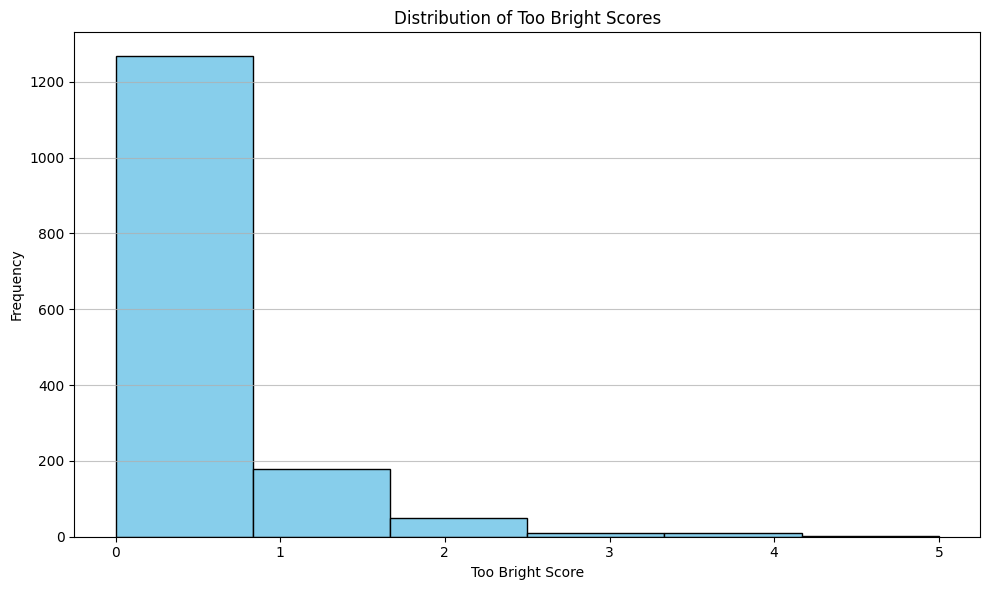

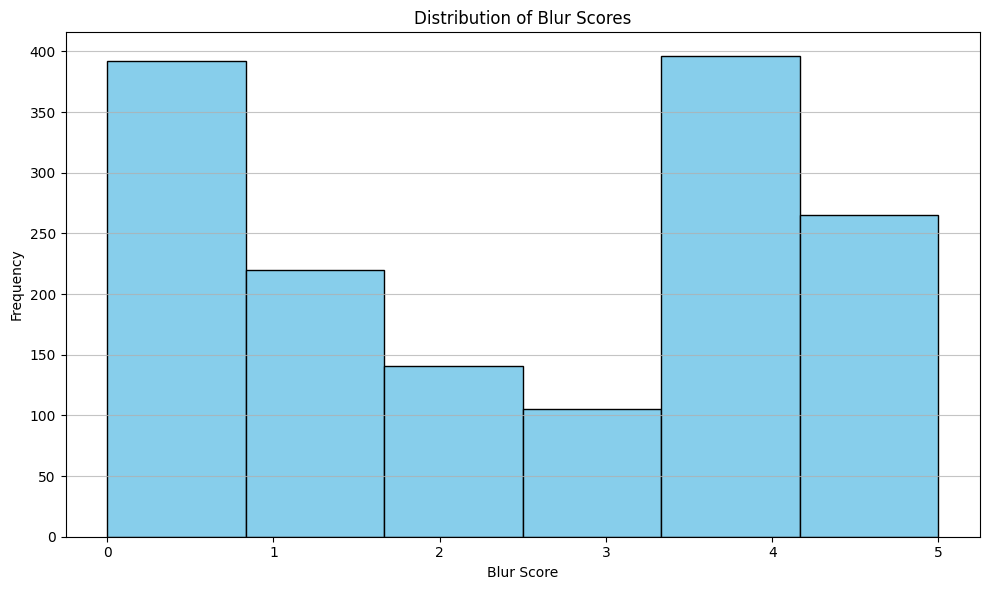

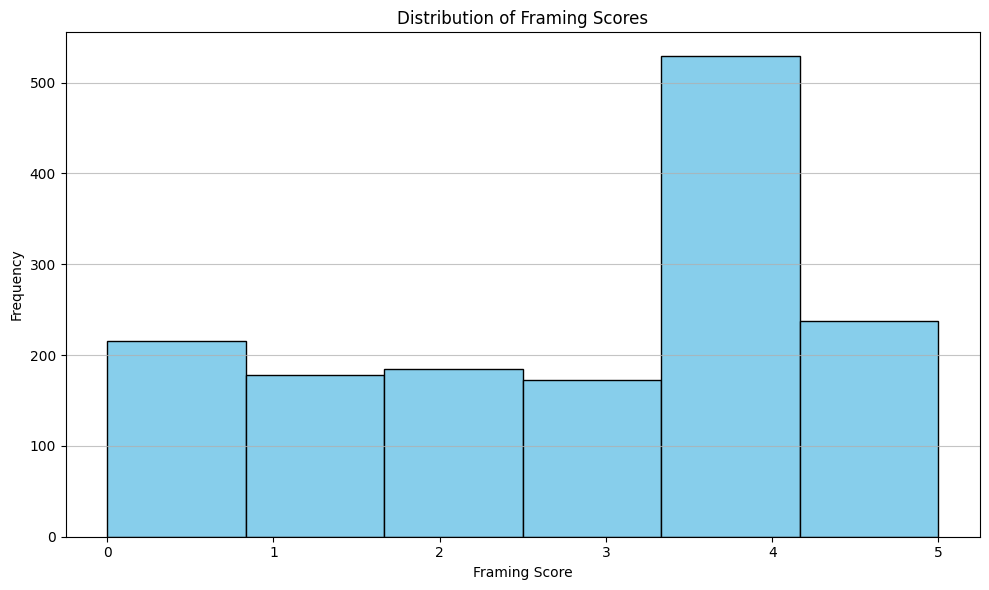

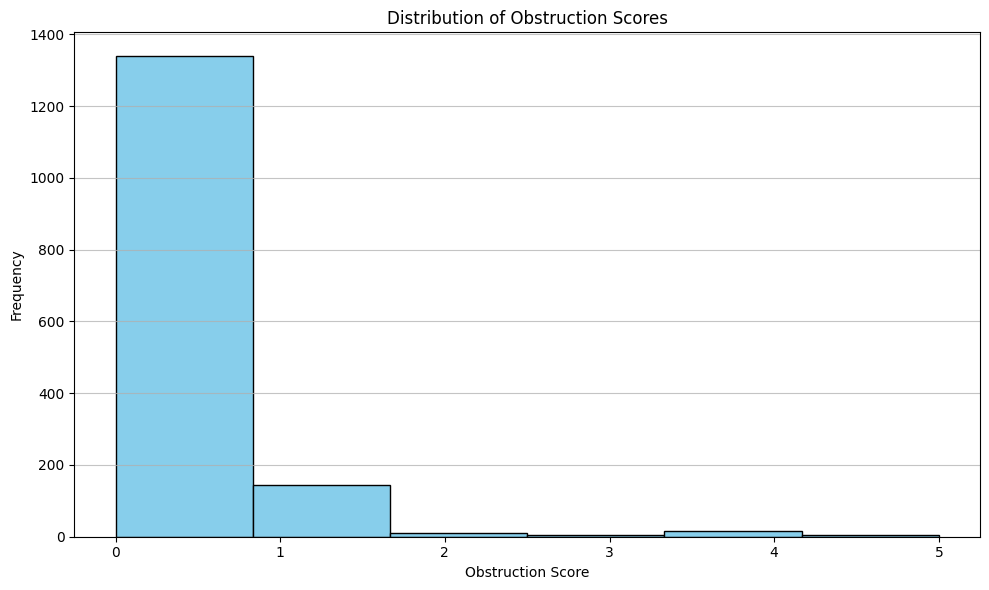

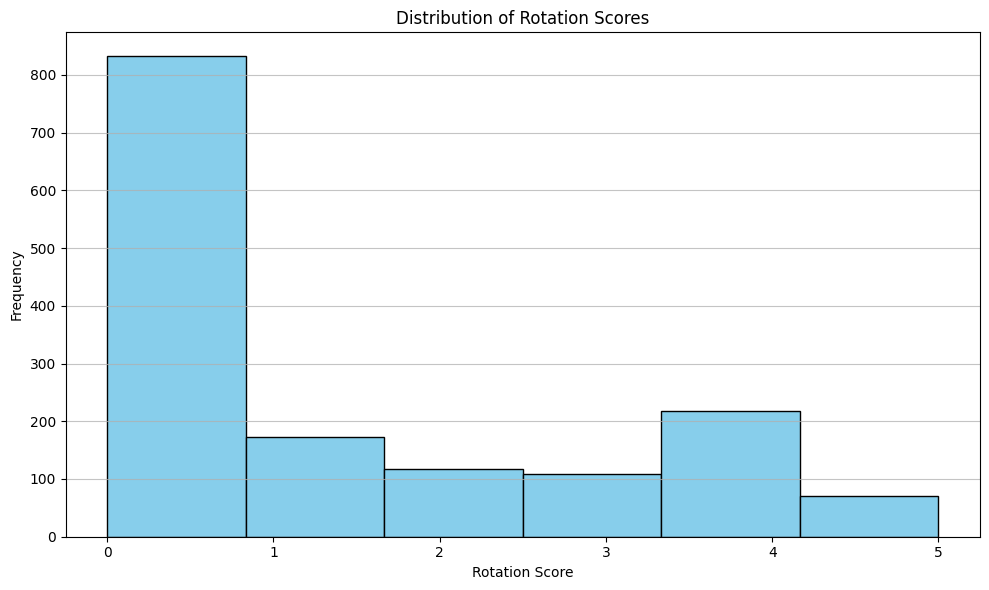

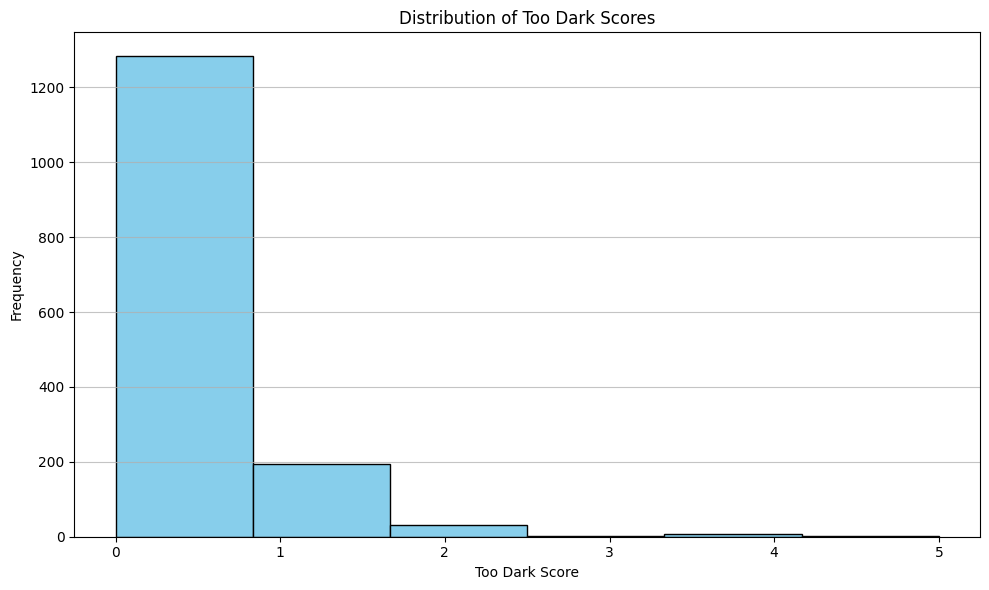

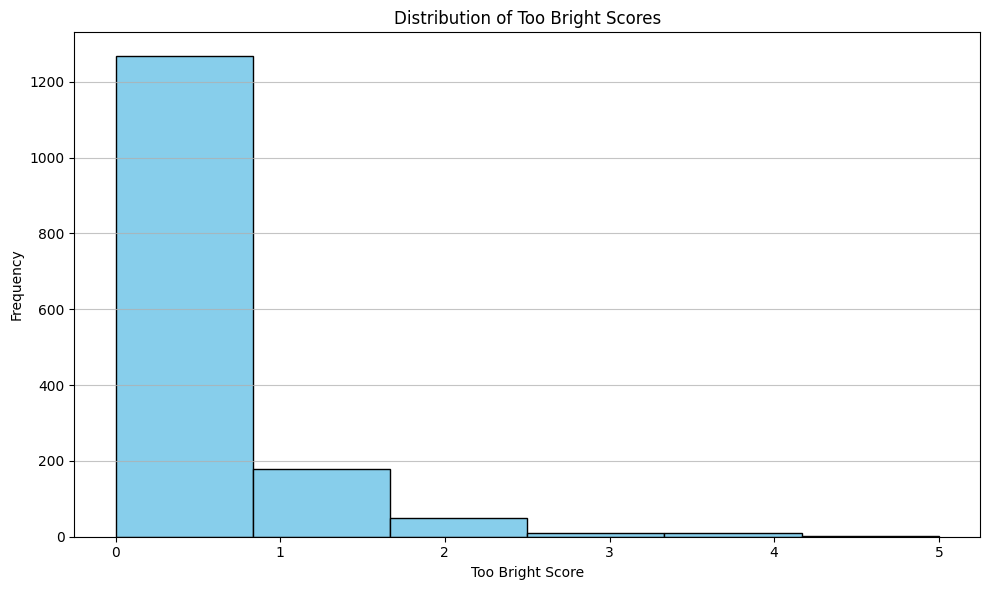

In [ ]:
# Function to plot a histogram of a single variable
def plot_histogram(
    data,
    column,
    title=None,
    xlabel=None,
    ylabel="Frequency",
    bins=10,
    figsize=(10, 6),
    color="skyblue",
    edgecolor="black",
):
    """
    Plot a histogram for a single variable.

    Parameters:
    -----------
    data : pandas.DataFrame or pandas.Series
        The data containing the variable to plot
    column : str
        The column name if data is a DataFrame
    title : str, optional
        The title of the plot
    xlabel : str, optional
        The label for the x-axis
    ylabel : str, optional
        The label for the y-axis
    bins : int, optional
        Number of bins in the histogram
    figsize : tuple, optional
        Figure size as (width, height)
    color : str, optional
        Color of the bars
    edgecolor : str, optional
        Color of the edges of the bars

    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)

    # If data is a DataFrame, extract the column
    if hasattr(data, "columns"):
        values = data[column]
    else:
        values = data
        if xlabel is None and column is not None:
            xlabel = column

    # Create the histogram
    plt.hist(values, bins=bins, color=color, edgecolor=edgecolor)

    # Set title and labels
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(axis="y", alpha=0.75)
    plt.tight_layout()

    return plt.gcf()


# Example usage:
plot_histogram(
    verification_of_annotations_df,
    "blur",
    title="Distribution of Blur Scores",
    xlabel="Blur Score",
    bins=6,
)
plot_histogram(
    verification_of_annotations_df,
    "framing",
    title="Distribution of Framing Scores",
    xlabel="Framing Score",
    bins=6,
)
plot_histogram(
    verification_of_annotations_df,
    "obstruction",
    title="Distribution of Obstruction Scores",
    xlabel="Obstruction Score",
    bins=6,
)
plot_histogram(
    verification_of_annotations_df,
    "rotation",
    title="Distribution of Rotation Scores",
    xlabel="Rotation Score",
    bins=6,
)
plot_histogram(
    verification_of_annotations_df,
    "too dark",
    title="Distribution of Too Dark Scores",
    xlabel="Too Dark Score",
    bins=6,
)
plot_histogram(
    verification_of_annotations_df,
    "too bright",
    title="Distribution of Too Bright Scores",
    xlabel="Too Bright Score",
    bins=6,
)

### Create a dataset with the remaining images to annotate with expert captions

In [33]:
# files that need captioning (all identified products - what was captioned).intersection(expert_file_set)
files_to_caption = set(original_file_set - annotated_file_set).intersection(
    expert_file_set
)
print(
    f"verify files left to caption is the same between difference of two above: {len(files_to_caption) == (len(expert_file_set.intersection(original_file_set)) - len(expert_file_set.intersection(annotated_file_set)))}"
)

verify files left to caption is the same between difference of two above: True


In [34]:
# start with the original dataframe we made for annotators and select only the files to caption above
expert_captions_annotations_remaining_df = human_coder_df[
    human_coder_df["file_name"].isin(files_to_caption)
]

# merge in expert captions
expert_captions_annotations_remaining_df = pd.merge(
    expert_captions_annotations_remaining_df,
    labeled_data[
        [
            "File Name",
            "Describe all parts of the image that may be important to a person who is blind.",
        ]
    ],
    right_on="File Name",
    left_on="file_name",
    how="inner",
)

# merge in model captions
expert_captions_annotations_remaining_df = pd.merge(
    expert_captions_annotations_remaining_df,
    verification_data_df[
        ["file_name", "gpt4o_caption", "llama_caption", "molmo_caption"]
    ],
    on="file_name",
    how="left",
)

# rename expert caption column
expert_captions_annotations_remaining_df.rename(
    columns={
        "Describe all parts of the image that may be important to a person who is blind.": "expert_caption"
    },
    inplace=True,
)


# add some extra columns for coding
expert_captions_annotations_remaining_df["annotator"] = ""
expert_captions_annotations_remaining_df["double code notes"] = ""
expert_captions_annotations_remaining_df["double verified"] = ""
list(expert_captions_annotations_remaining_df.columns)

# reorder columns
expert_captions_annotations_remaining_df = expert_captions_annotations_remaining_df[
    [
        "image_id",
        "file_name",
        "vizwiz_url",
        "image_preview",
        "human_captions",
        "expert_caption",
        "annotator",
        "notes",
        "unable_to_verify",
        "double code notes",
        "double verified",
        "gpt4o_caption",
        "gpt4o_g_atomics",
        "gpt4o_recall_tp",
        "gpt4o_recall_fn",
        "gpt4o_precision_tp",
        "gpt4o_precision_fp",
        "gpt4o_code",
        "llama_caption",
        "llama_g_atomics",
        "llama_recall_tp",
        "llama_recall_fn",
        "llama_precision_tp",
        "llama_precision_fp",
        "llama_code",
        "molmo_caption",
        "molmo_g_atomics",
        "molmo_recall_tp",
        "molmo_recall_fn",
        "molmo_precision_tp",
        "molmo_precision_fp",
        "molmo_code",
    ]
]

# print number of rows
print(len(expert_captions_annotations_remaining_df))
display(expert_captions_annotations_remaining_df.head())

# save the human coder dataframe
expert_captions_annotations_remaining_df.to_csv(
    f"./data-to-label/remaining-expert-captions_{len(expert_captions_annotations_remaining_df)}-images_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv",
    index=False,
)

177


,image_id,file_name,vizwiz_url,image_preview,human_captions,expert_caption,annotator,notes,unable_to_verify,double code notes,double verified,gpt4o_caption,gpt4o_g_atomics,gpt4o_recall_tp,gpt4o_recall_fn,gpt4o_precision_tp,gpt4o_precision_fp,gpt4o_code,llama_caption,llama_g_atomics,llama_recall_tp,llama_recall_fn,llama_precision_tp,llama_precision_fp,llama_code,molmo_caption,molmo_g_atomics,molmo_recall_tp,molmo_recall_fn,molmo_precision_tp,molmo_precision_fp,molmo_code
0,19845,VizWiz_train_00019845.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,Quality issues are too severe to recognize vis...,"Blurry, sideways view of the backside of a shi...",,,,,,"A package with a blue and white design, featur...",There is a package.\nThe package has a blue de...,The bag has a nutritional label.,There is a foil bag.\nThe bag contains potato ...,There is a package.\nThe package features nutr...,The package has a blue design.\nThe package ha...,,"The image shows a partially visible, open bag ...",There is a bag of potato chips.\nThe bag of po...,There is a bag of sea salt chips.\nThe bag con...,There is a foil bag.\nThe bag has a nutritiona...,There is a bag of potato chips.,The bag of potato chips is partially visible.\...,,"The image shows a snack package, likely a gran...",There is a snack package.\nThe package is like...,,There is a foil bag.\nThe bag contains potato ...,There is a snack package.,The package is likely a granola or protein bar...,
1,14116,VizWiz_train_00014116.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A yellow tube of anti itch cream by the brand ...,A close-up image of a yellow and blue tube of ...,,,,,,Tube of Lanicane Maximum Strength Anti-Itch Cr...,There is a tube of Lanicane Maximum Strength A...,The tube is yellow.\nThe tube contains anti it...,The anti itch cream is medication.\nThe contai...,There is a tube of Lanicane Maximum Strength A...,The tube has a blue label.\nThe text on the tu...,,The image shows a yellow and blue tube of Lana...,There is a tube of Lanacane.\nThe tube is yell...,The tube is yellow.\nThe brand of the cream is...,The tube contains anti itch cream.\nThe cream ...,There is a tube of Lanacane.\nThe tube is yell...,The tube is blue.\nThe tube has a blue hexagon...,,The image shows a tube of toothpaste lying on ...,There is a tube of toothpaste.\nThe toothpaste...,The tube is yellow.\nThe tube of cream is on t...,The tube contains anti itch cream.\nThe brand ...,The toothpaste tube is lying on a surface.\nTh...,There is a tube of toothpaste.\nThe toothpaste...,
2,17585,VizWiz_train_00017585.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,a package of blue yarn on a wood table\nA ball...,A close-up of a skein of teal-colored yarn lab...,,,,,,A roll of yarn with a label is partially visib...,There is a roll of yarn.\nThe roll of yarn has...,There is a ball of yarn.\nThe label is for a s...,The package contains yarn.\nThe yarn is blue.\...,There is a roll of yarn.\nThe roll of yarn has...,The label on the yarn is partially visible.\nT...,,The image shows a white computer keyboard with...,There is a computer keyboard.\nThe keyboard is...,The keyboard is white.,The package contains yarn.\nThe yarn is blue.\...,There is a computer keyboard.\nThe keyboard is...,There is a gray keycap on the keyboard.\nThe g...,,"A rolled-up blue fabric, likely a sweater or b...",There is a rolled-up blue fabric.\nThe fabric ...,The yarn is blue.\nThe package is on a table.\...,The package contains yarn.\nThere is a ball of...,There is a rolled-up blue fabric.\nThe fabric ...,The label features a blue circle.\nThe label h...,
3,5029,VizWiz_train_00005029.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A Marie Callender's frozen entree rests on a w...,An upside-down frozen meal box showing a bread...,,,,,,A packaged meal with an image of breaded chick...,There is a packaged meal.\nThere is an image o...,There is a Marie Callender's frozen entree.\nT...,The entree is on a stove top.\nT

## Constuct the tables we need for analysis

In [35]:
# made an analysis df that only keeps the columns we want to analyze
annotated_analysis_df = annotated_df[columns_to_keep]
annotated_analysis_df.head()

,image_id,file_name,vizwiz_url,image_preview,human_captions,annotator,double code notes,double verified,unable_to_verify,gpt4o_code,llama_code,molmo_code,notes
0,9886,VizWiz_train_00009886.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A box of frozen food sits on a table top that ...,Anne Marie,,x,,yes,yes,no,trade joes paneer tikka masala
1,12066,VizWiz_train_00012066.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A Kroger grocery store tag for a caramel iced ...,Anne Marie,,x,,yes,no,no,kroger iced carmel cake
2,1908,VizWiz_train_00001908.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A description on a box of herbal tea.\nA print...,Anne Marie,,x,,yes,yes,yes,caffeine free herb tea
3,15399,VizWiz_train_00015399.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,A green and white box of Lean Pockets frozen r...,Anne Marie,,x,,yes,yes,no,lean pocket garlic chicken white pizza
4,4380,VizWiz_train_00004380.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,,garlic spinach hummus possibly in a green cont...,Anne Marie,garlic spinach hummus,x,yes,,,,


In [36]:
# count if not unable to verify
# Create a table showing the counts of different code values for each model
code_counts = pd.DataFrame(
    {
        "GPT-4o": annotated_analysis_df[
            annotated_analysis_df["unable_to_verify"] == ""
        ]["gpt4o_code"].value_counts(),
        "Llama": annotated_analysis_df[annotated_analysis_df["unable_to_verify"] == ""][
            "llama_code"
        ].value_counts(),
        "Molmo": annotated_analysis_df[annotated_analysis_df["unable_to_verify"] == ""][
            "molmo_code"
        ].value_counts(),
    }
)

# Fill NaN values with 0 and convert to integers
code_counts = code_counts.fillna(0).astype(int)

# Display the table
display(code_counts)

,GPT-4o,Llama,Molmo
,1,0,3
no,292,505,612
unsure,2,2,2
yes,744,550,447
yes++,26,8,1


# Load the labeled data and prepare it for regression analysis

In [166]:
# load csv
labeled_data = pd.read_csv(
    "./labeled-data/Dataset for Shawn _ 04-06-25 - dataset formatted.csv"
)
labeled_data.head()

,File Name,Image URL,Image Preview,Captioner Name,Describe all parts of the image that may be important to a person who is blind.,"If you are unable to caption the image, describe the issue in this column."
0,VizWiz_train_00019710.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,NaN,sm,Two bulldogs are lying side by side on a white...,NaN
1,VizWiz_train_00008349.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,NaN,sm,A box of “Café Escapes” dark chocolate hot coc...,NaN
2,VizWiz_train_00003852.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,NaN,sm,A clear plastic container of Kirkland Signatur...,NaN
3,VizWiz_train_00014314.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,NaN,sm,A close-up photo of a black computer keyboard ...,NaN
4,VizWiz_train_00016316.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,NaN,sm,A can of Progresso soup is being held up close...,NaN


In [173]:
len(set(human_coder_df["file_name"]).intersection(set(labeled_data["File Name"])))

349